In [1]:
from pathlib import Path

import colorcet as cc
import h5py
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import scipy
import skimage


datadir = Path("../data/SIM")


In [2]:
def read_SIM_data(filepath: Path | str):
    f = h5py.File(filepath)
    data = f["Data"][:]
    pixel_sizes = f["Data"].attrs["pixel_sizes"]
    dtype = data.dtype
    if dtype.kind == "u":
        data = data / np.iinfo(dtype).max
    return data, pixel_sizes


data, pixel_sizes = read_SIM_data(datadir / "myosin/Image20_myosin_SIM2.h5")
roi = (slice(10, 30), slice(200, 400), slice(200, 400))
data.dtype

dtype('float64')

In [3]:
pixel_sizes

array([0.14412245, 0.03130297, 0.03130297], dtype=float32)

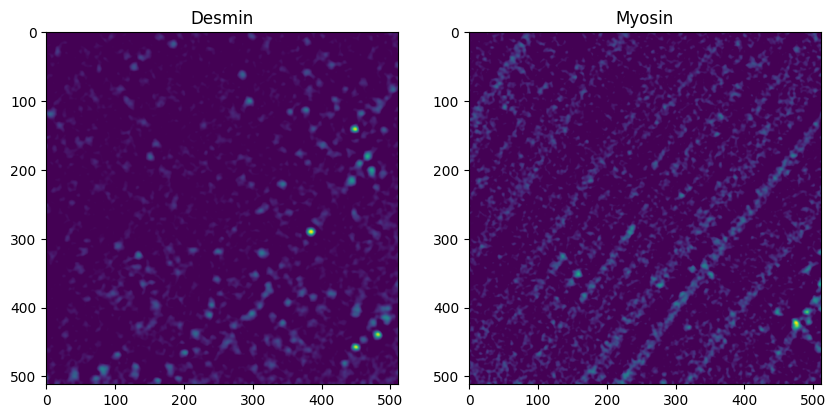

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i, (ax, name) in enumerate(zip(axes, ("Desmin", "Myosin"))):
    # ax.imshow(np.mean(actin[i, :, 200:1200, 1000:2000], axis=0))
    # ax.imshow(np.mean(data[i, *roi], axis=0))
    ax.imshow(data[i, 20])
    ax.set_title(name)

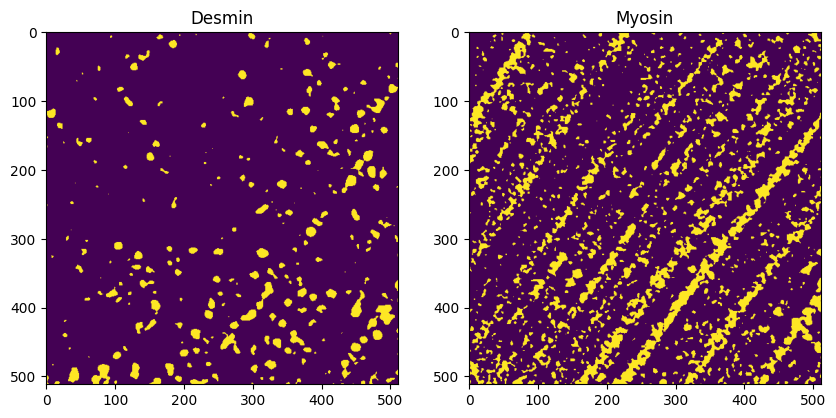

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i, (ax, name) in enumerate(zip(axes, ("Desmin", "Myosin"))):
    # ax.imshow(np.mean(actin[i, :, 200:1200, 1000:2000], axis=0))
    img = data[i, 20]
    binarized = img > skimage.filters.threshold_otsu(img)
    ax.imshow(binarized)
    ax.set_title(name)

In [75]:
data[0].shape

(39, 512, 512)

In [ ]:
from scipy import signal as scsignal


img = data[0] - np.mean(data[0])
out = scsignal.correlate(img, img, mode="full")
out.shape

(77, 1023, 1023)

FWHM y: 101
FWHM z: 7


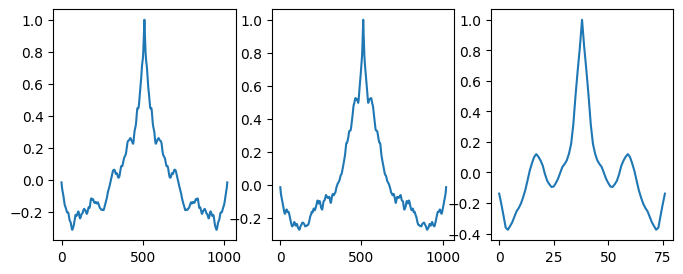

In [ ]:
autocorr_z = np.mean(out, axis=(1, 2))
autocorr_z = autocorr_z / np.max(autocorr_z)
autocorr_y = np.mean(out, axis=(0, 2))
autocorr_y = autocorr_y / np.max(autocorr_y)
autocorr_x = np.mean(out, axis=(0, 1))
autocorr_x = autocorr_x / np.max(autocorr_x)
fwhm_x = np.sum(autocorr_x - 0.5 >= 0)
fwhm_y = np.sum(autocorr_y - 0.5 >= 0)
fwhm_z = np.sum(autocorr_z - 0.5 >= 0)
print(f"FWHM y: {fwhm_y}")
print(f"FWHM z: {fwhm_z}")
fig, axes = plt.subplots(1, 3, figsize=(8, 3))
axes[0].plot(autocorr_x)
axes[1].plot(autocorr_y)
axes[2].plot(autocorr_z)


In [112]:
rng = np.random.default_rng()
chunk_sample_shape = (
    data[0].shape[-1] // fwhm_x + 1,
    data[0].shape[-2] // fwhm_y + 1,
    data[0].shape[-3] // fwhm_z + 1,
)
N = (
    (data[0].shape[-1] // fwhm_x + 1)
    * (data[0].shape[-2] // fwhm_y + 1)
    * (data[0].shape[-3] // fwhm_z + 1)
)
idx_x = rng.integers(0, data[0].shape[-1] - fwhm_x, N)
idx_y = rng.integers(0, data[0].shape[-2] - fwhm_y, N)
idx_z = rng.integers(0, data[0].shape[-3] - fwhm_z, N)

In [113]:
chunks = np.array(
    [
        data[0][k : k + fwhm_z, j : j + fwhm_y, i : i + fwhm_x]
        for i, j, k in zip(idx_x, idx_y, idx_z)
    ]
)

In [114]:
chunks = chunks.reshape((*chunk_sample_shape, fwhm_z, fwhm_y, fwhm_x))

In [115]:
chunks.shape

(9, 6, 6, 7, 101, 63)

In [116]:
img.shape

(39, 512, 512)

In [117]:
img_resampled = np.concatenate(
    np.concatenate(np.concatenate(chunks, axis=-1), axis=-2), axis=-3
)
img_resampled = img_resampled[0 : img.shape[0], 0 : img.shape[1], 0 : img.shape[2]]

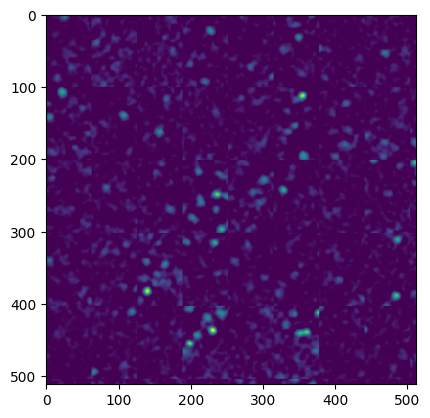

In [118]:
plt.imshow(img_resampled[20])

Text(0.6174999999999999, 0.5850000000000001, '$r=-0.1554$')

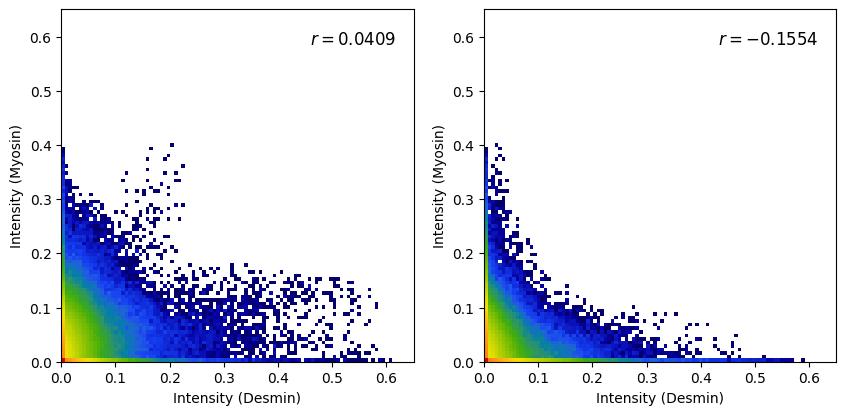

In [119]:
def pearson_correlation_coefficient(channel_1, channel_2):
    threshold_1 = skimage.filters.threshold_otsu(channel_1)
    threshold_2 = skimage.filters.threshold_otsu(channel_2)

    mask = np.logical_and(channel_1 >= threshold_1, channel_2 >= threshold_2)
    return scipy.stats.pearsonr(channel_1[mask], channel_2[mask]), (
        threshold_1,
        threshold_2,
    )


fig, axes = plt.subplots(1, 2, figsize=(10, 5))
range_max = 0.65

corrcoef, thresholds = pearson_correlation_coefficient(*data[:, *roi])
h = axes[0].hist2d(
    data[0, *roi].flatten(),
    data[1, *roi].flatten(),
    bins=100,
    range=[[0, range_max], [0, range_max]],
    norm=mcolors.LogNorm(),
    cmap=cc.cm.rainbow4,
)
axes[0].set_aspect("equal", "box")
fig.colorbar(h[3], ax=ax, label="Number of voxels")

axes[0].set_xlabel("Intensity (Desmin)")
axes[0].set_ylabel("Intensity (Myosin)")
axes[0].text(
    0.95 * range_max,
    0.9 * range_max,
    f"$r={corrcoef.statistic:.4f}$",
    color="black",
    fontsize="large",
    fontweight="bold",
    ha="right",
)

corrcoef, thresholds = pearson_correlation_coefficient(
    img_resampled[*roi], data[1, *roi]
)
h = axes[1].hist2d(
    img_resampled[*roi].flatten(),
    data[1, *roi].flatten(),
    bins=100,
    range=[[0, range_max], [0, range_max]],
    norm=mcolors.LogNorm(),
    cmap=cc.cm.rainbow4,
)
axes[1].set_aspect("equal", "box")
fig.colorbar(h[3], ax=ax, label="Number of voxels")

axes[1].set_xlabel("Intensity (Desmin)")
axes[1].set_ylabel("Intensity (Myosin)")
axes[1].text(
    0.95 * range_max,
    0.9 * range_max,
    f"$r={corrcoef.statistic:.4f}$",
    color="black",
    fontsize="large",
    fontweight="bold",
    ha="right",
)

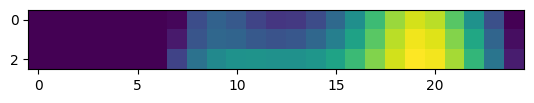

In [74]:
plt.imshow(data[0][:fwhm_z, :fwhm_y, 200])

In [ ]:
autocorr_x = np.mean(out, axis=(1, 2))
autocorr_x = autocorr_x / np.max(autocorr_x)
print(f"FWHM x: {np.sum(autocorr_x - 0.5 >= 0)}")
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(autocorr_x)


np.int64(7)

In [57]:
stuff = np.mean(out, axis=(1, 2))
stuff[0]

np.float64(-0.15762514497912172)

In [60]:
stuff - stuff[::-1]

array([ 1.11022302e-16,  2.77555756e-17,  1.66533454e-16, -2.22044605e-16,
        1.11022302e-16,  5.55111512e-16,  1.72084569e-15, -7.21644966e-16,
        1.22124533e-15, -2.22044605e-16,  2.41473508e-15, -4.16333634e-16,
        2.44249065e-15,  1.26287869e-15,  4.14598911e-16, -1.11022302e-15,
       -5.96744876e-16,  4.99600361e-16, -1.54043445e-15, -5.82867088e-16,
       -1.80411242e-16,  1.32706346e-15,  7.63278329e-16,  1.05471187e-15,
        4.57966998e-16,  2.06779038e-15, -1.30451205e-15,  8.11850587e-16,
        9.80118764e-16, -1.53349555e-15,  2.75474088e-15, -7.91033905e-16,
       -7.35522754e-15,  2.22044605e-16,  2.22044605e-16, -1.66533454e-15,
       -2.22044605e-16,  4.44089210e-15,  0.00000000e+00, -4.44089210e-15,
        2.22044605e-16,  1.66533454e-15, -2.22044605e-16, -2.22044605e-16,
        7.35522754e-15,  7.91033905e-16, -2.75474088e-15,  1.53349555e-15,
       -9.80118764e-16, -8.11850587e-16,  1.30451205e-15, -2.06779038e-15,
       -4.57966998e-16, -

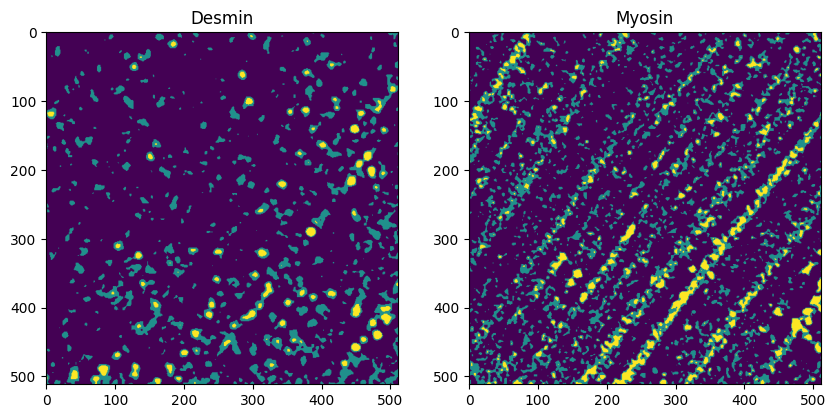

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i, (ax, name) in enumerate(zip(axes, ("Desmin", "Myosin"))):
    # ax.imshow(np.mean(actin[i, :, 200:1200, 1000:2000], axis=0))
    img = data[i, 20]
    thresholds = skimage.filters.threshold_multiotsu(img)
    ax.imshow(np.digitize(img, bins=thresholds))
    ax.set_title(name)

(0.0, 0.2)

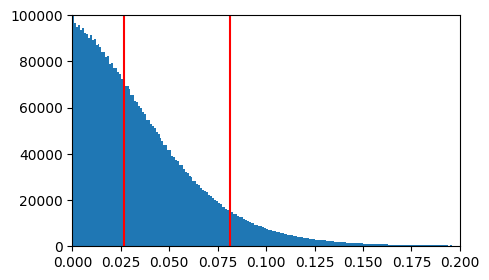

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.hist(data[1].flatten(), bins=1000)
ax.axvline(thresholds[0], color="red")
ax.axvline(thresholds[1], color="red")
ax.set_ylim((0, 100000))
ax.set_xlim((0, 0.2))

In [30]:
def pearson_correlation_coefficient(channel_1, channel_2):
    threshold_1 = skimage.filters.threshold_otsu(channel_1)
    threshold_2 = skimage.filters.threshold_otsu(channel_2)

    mask = np.logical_and(channel_1 >= threshold_1, channel_2 >= threshold_2)
    return scipy.stats.pearsonr(channel_1[mask], channel_2[mask]), (
        threshold_1,
        threshold_2,
    )


corrcoef, thresholds = pearson_correlation_coefficient(*data[:, *roi])

In [31]:
corrcoef.statistic

np.float64(0.04087356408293242)

Text(0.6174999999999999, 0.5850000000000001, '$r=0.0409$')

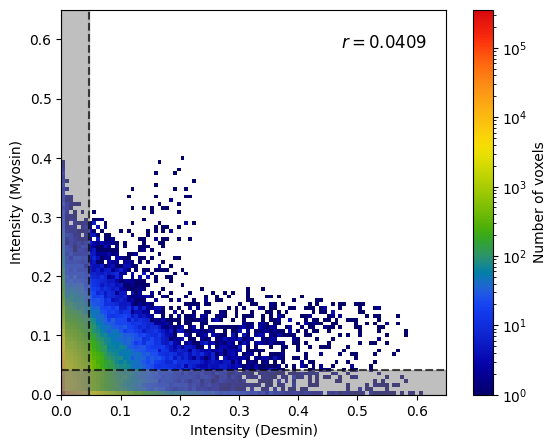

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
range_max = 0.65
h = ax.hist2d(
    data[0, *roi].flatten(),
    data[1, *roi].flatten(),
    bins=100,
    range=[[0, range_max], [0, range_max]],
    norm=mcolors.LogNorm(),
    cmap=cc.cm.rainbow4,
)
ax.set_aspect("equal", "box")
fig.colorbar(h[3], ax=ax, label="Number of voxels")
ax.axvline(x=thresholds[0], ls="--", color="black", alpha=0.7)
ax.axvspan(0.0, thresholds[0], color="gray", alpha=0.5)
ax.axhline(y=thresholds[1], ls="--", color="black", alpha=0.7)
ax.axhspan(0.0, thresholds[1], color="gray", alpha=0.5)
ax.set_xlabel("Intensity (Desmin)")
ax.set_ylabel("Intensity (Myosin)")
ax.text(
    0.95 * range_max,
    0.9 * range_max,
    f"$r={corrcoef.statistic:.4f}$",
    color="black",
    fontsize="large",
    fontweight="bold",
    ha="right",
)

In [35]:
data, pixel_sizes = read_SIM_data(datadir / "actin/Image10_actin_SIM2.h5")
roi = (slice(10, 33), slice(1200, 1600), slice(200, 600))

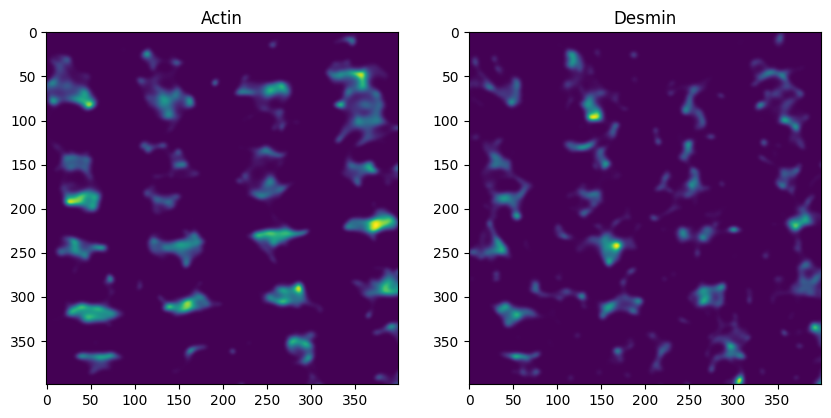

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i, (ax, name) in enumerate(zip(axes, ("Actin", "Desmin"))):
    # ax.imshow(np.mean(actin[i, :, 200:1200, 1000:2000], axis=0))
    ax.imshow(np.mean(data[i, *roi], axis=0))
    ax.set_title(name)

In [37]:
corrcoef, thresholds = pearson_correlation_coefficient(data[1, *roi], data[0, *roi])

Text(0.6174999999999999, 0.5850000000000001, '$r=0.2458$')

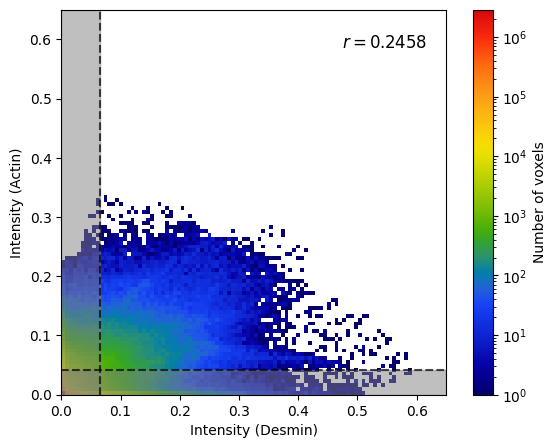

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
range_max = 0.65
h = ax.hist2d(
    data[1, *roi].flatten(),
    data[0, *roi].flatten(),
    bins=100,
    range=[[0, range_max], [0, range_max]],
    norm=mcolors.LogNorm(),
    cmap=cc.cm.rainbow4,
)
ax.set_aspect("equal", "box")
fig.colorbar(h[3], ax=ax, label="Number of voxels")
ax.axvline(x=thresholds[0], ls="--", color="black", alpha=0.7)
ax.axvspan(0.0, thresholds[0], color="gray", alpha=0.5)
ax.axhline(y=thresholds[1], ls="--", color="black", alpha=0.7)
ax.axhspan(0.0, thresholds[1], color="gray", alpha=0.5)
ax.set_xlabel("Intensity (Desmin)")
ax.set_ylabel("Intensity (Actin)")
ax.text(
    0.95 * range_max,
    0.9 * range_max,
    f"$r={corrcoef.statistic:.4f}$",
    color="black",
    fontsize="large",
    fontweight="bold",
    ha="right",
)

In [39]:
data, pixel_sizes = read_SIM_data(datadir / "alpha-actinin/Image2_SIM2.h5")
roi = (slice(10, 33), slice(200, 600), slice(1000, 1400))

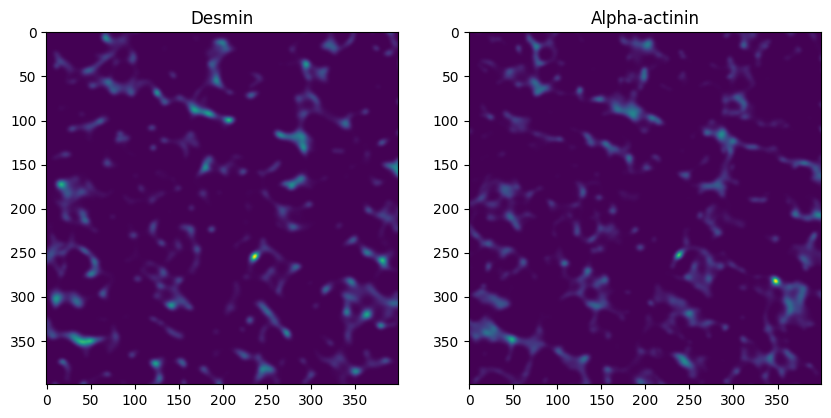

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i, (ax, name) in enumerate(zip(axes, ("Desmin", "Alpha-actinin"))):
    # ax.imshow(np.mean(actin[i, :, 200:1200, 1000:2000], axis=0))
    ax.imshow(np.mean(data[i, *roi], axis=0))
    ax.set_title(name)

In [41]:
corrcoef, thresholds = pearson_correlation_coefficient(*data[:, *roi])

Text(0.6174999999999999, 0.5850000000000001, '$r=0.1666$')

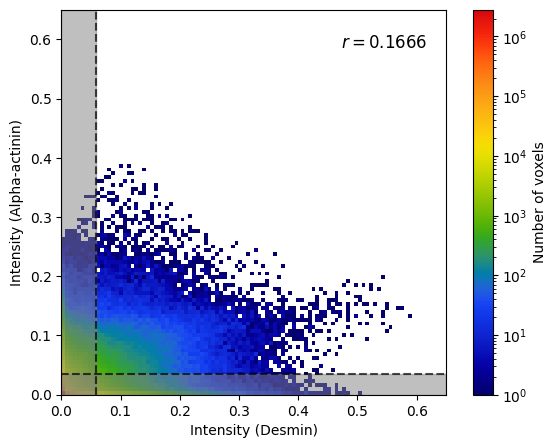

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
range_max = 0.65
h = ax.hist2d(
    data[0, *roi].flatten(),
    data[1, *roi].flatten(),
    bins=100,
    range=[[0, range_max], [0, range_max]],
    norm=mcolors.LogNorm(),
    cmap=cc.cm.rainbow4,
)
ax.set_aspect("equal", "box")
fig.colorbar(h[3], ax=ax, label="Number of voxels")
ax.axvline(x=thresholds[0], ls="--", color="black", alpha=0.7)
ax.axvspan(0.0, thresholds[0], color="gray", alpha=0.5)
ax.axhline(y=thresholds[1], ls="--", color="black", alpha=0.7)
ax.axhspan(0.0, thresholds[1], color="gray", alpha=0.5)
ax.set_xlabel("Intensity (Desmin)")
ax.set_ylabel("Intensity (Alpha-actinin)")
ax.text(
    0.95 * range_max,
    0.9 * range_max,
    f"$r={corrcoef.statistic:.4f}$",
    color="black",
    fontsize="large",
    fontweight="bold",
    ha="right",
)